In [14]:
!pip install tsfresh

  Obtaining dependency information for tsfresh from https://files.pythonhosted.org/packages/62/72/cf614f4dc6fa0d16f6cbf9e97d464cfdf60eca7e051bcaa3f403572c007c/tsfresh-0.20.1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 9.5 MB/s eta 0:00:00:00:0100:01
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
  Obtaining dependency information for dask[dataframe]>=2.9.0 from https://files.pythonhosted.org/packages/f5/ec/3613b5221a015f54ff50a948029bbd7564e846a45178070feced8b9d105c/dask-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for distributed>=2.11.0 from https://files.pythonhosted.org/packages/63/17/ad16f15b7e78d15265086f7da8c52eda1483e97affc796ccd75e654573cb/distributed-2023.9.2-py3-none-any.whl.metadata
  Obtaining dependency information for stumpy>=1.7.2 from https://files.pythonhosted.org/packages/c4/9d/9752261f8fe19ab4239caf1ba3864b04a0d7ab0033155cb11f86f124a642/stumpy-1.12.0-py3-none-any.whl.metadata
  Obtaining d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.9/994.9 kB 23.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 10.3 MB/s eta 0:00:0000:0100:01


In [39]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import errno
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from functools import reduce
from sklearn.model_selection import GridSearchCV


# suppress Pandas warnings for more readbility
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')


from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


### Prétraitement de données 

### Condition de la variable cible

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). 
As before, the row number represents the cycle number.


The columns are 

1: Cooler condition / %: 
3: close to total failure 
20: reduced effifiency 
100: full efficiency 

2: Valve condition / %: 
100: optimal switching behavior 
90: small lag 
80: severe lag 
73: close to total failure 

3: Internal pump leakage: 
0: no leakage 
1: weak leakage 
2: severe leakage 

4: Hydraulic accumulator / bar: 
130: optimal pressure 
115: slightly reduced pressure 
100: severely reduced pressure 
90: close to total failure 

5: stable flag: 
0: conditions were stable 
1: static conditions might not have been reached yet

In [40]:
# Load in the target variables as a Pandas DataFrame
names = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

condition = pd.read_csv('profile.txt',delim_whitespace=True,header=None,names =names)

# Preview the first few lines
condition

,cooler_condition,valve_condition,pump_leak,hydraulic_accumulator,stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
...,...,...,...,...,...
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0


In [41]:
# check for irregular values and there was none
for i in enumerate(list(names)):
    print(pd.unique(condition[i[1]]))

[  3  20 100]
[100  73  80  90]
[0 2 1]
[130 115 100  90]
[1 0]


Visualisation de la variable cible

<AxesSubplot:xlabel='stable_flag', ylabel='Density'>

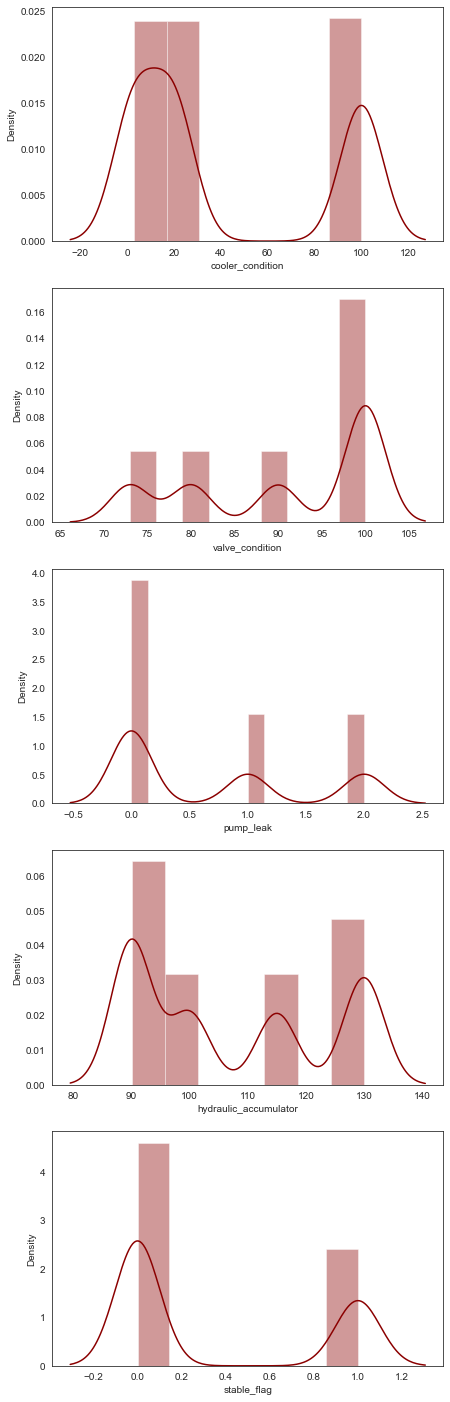

In [44]:
# Construct 5 subplots for the 5 target variables    
figure,(ax1, ax2,ax3,ax4,ax5) = plt.subplots(figsize=(7, 25 ), 
                       nrows=condition.shape[1], ncols=1,sharex = False)
# 
sns.distplot(condition[names[0]], hist=True, color = 'darkred',ax=ax1)
sns.distplot(condition[names[1]], hist=True,color = 'darkred',ax=ax2)
sns.distplot(condition[names[2]], hist=True, color = 'darkred',ax=ax3)
sns.distplot(condition[names[3]], hist=True,color = 'darkred',ax=ax4)
sns.distplot(condition[names[4]], hist=True, color = 'darkred',ax=ax5)

### Load the feature time series data 

In [45]:
# import all the feature variables at once
path = 'features/*.txt'
# find all the txt files in the path 
files = glob.glob(path)
# use a dict to save all the variables 
features = {}

for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
            

In [46]:
# rename the columns of the variables 
keylist = list(features.keys())

for key in keylist:
    features[key].columns=['seconds','cycle',key]

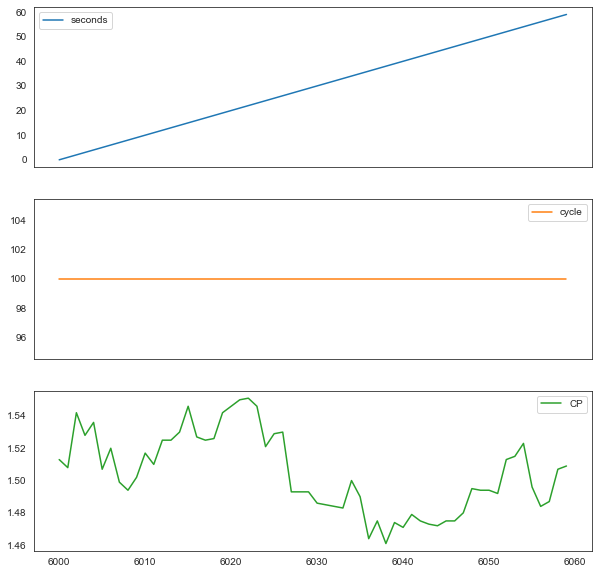

In [47]:
# show an example figure of sensor changes in 60 seconds
features['CP'][features['CP']['cycle']==100].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

### Data Description

#### Variable cible  : Valve condition

Valve condition %:

100: optimal switching behavior

90: small lag

80: severe lag 

73: close to total failure 

In [48]:
condition['valve_condition'].describe()

count    2205.000000
mean       90.693878
std        10.681802
min        73.000000
25%        80.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: valve_condition, dtype: float64

<AxesSubplot:xlabel='valve_condition', ylabel='Density'>

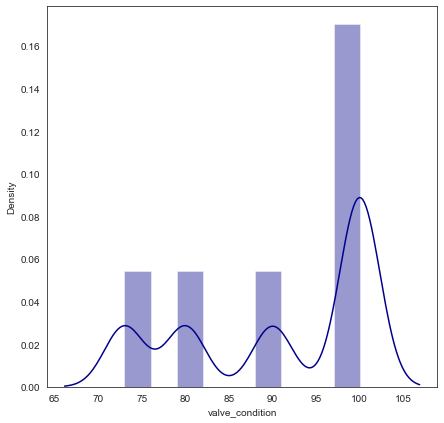

In [49]:
figure,ax = plt.subplots(figsize=(7, 7), sharex = False)
sns.distplot(condition['valve_condition'], hist=True,color = 'darkblue',ax=ax)


### Joining features, feature extraction and feature selection using tsfresh

In [50]:
# make the dataframes into a list 
dfs= [features['CP'],features['CE'],features['EPS1'],features['FS1'],features['FS2'],features['PS1'],features['PS2'],features['PS3'],
     features['PS4'],features['PS5'],features['PS6'],features['SE'],features['TS1'],features['TS2'],features['TS3'],features['TS4'],
     features['VS1']]  

# joining different features based on seconds and cycle
features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)
features_join.head()


,seconds,cycle,CP,CE,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,0,0,2.184,47.202,2411.6,8.990,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.570,40.961,38.320,30.363,0.604
1,1,0,2.184,47.273,2411.6,0.770,10.174,151.45,125.39,2.305,0.0,9.947,9.823,0.000,35.492,40.949,38.332,30.375,0.605
2,2,0,2.184,47.250,2411.6,0.641,10.151,151.52,125.40,2.336,0.0,9.964,9.844,0.000,35.469,40.965,38.320,30.367,0.611
3,3,0,2.185,47.332,2411.6,0.006,10.149,151.27,125.03,2.578,0.0,9.989,9.861,0.000,35.422,40.922,38.324,30.367,0.603
4,4,0,2.178,47.213,2411.6,0.000,10.172,150.80,124.05,2.977,0.0,9.996,9.877,0.000,35.414,40.879,38.332,30.379,0.608


Ci-dessous, j'utilise l'éxtraction automatique et la sélection des caractéristiques avec tsfresh package.

In [52]:
# Automatic feautre extraction using the tsfresh package
extracted_features = extract_features(features_join, column_id="cycle", column_sort="seconds")
# Impute any possible missing values 
impute(extracted_features)

# select the more relevant features with regard to the valve condition.
features_filtered = select_features(extracted_features, condition['valve_condition'])

Feature Extraction: 100%|██████████| 20/20 [08:04<00:00, 24.23s/it]


In [53]:
features_filtered.head()

,SE__ar_coefficient__coeff_10__k_10,"SE__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)","SE__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","SE__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","SE__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)",...,TS3__kurtosis,"VS1__fft_coefficient__attr_""real""__coeff_15",SE__approximate_entropy__m_2__r_0.1,"TS2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",SE__time_reversal_asymmetry_statistic__lag_2,SE__time_reversal_asymmetry_statistic__lag_1,"TS3__fft_coefficient__attr_""abs""__coeff_18","TS2__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","TS2__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","TS3__fft_coefficient__attr_""real""__coeff_4"
0,-0.019990,-27.596950,-13.394721,-59.610291,123.166684,22.657000,135.049766,-69.146999,-46.560969,-54.220684,...,-0.664441,0.013,0.382694,0.020281,11165.058375,5393.316246,0.232453,0.000738,0.001348,-0.252027
1,-0.022275,-27.240551,-13.303555,-58.749215,122.032900,22.578476,133.938035,-68.757818,-45.434743,-52.707259,...,-0.936856,0.082,0.385361,0.030206,11940.571877,5772.836422,0.459333,0.000493,0.000986,-0.649945
2,-0.020933,-27.528574,-13.415471,-59.241101,123.056925,23.049190,135.024418,-69.120107,-45.970105,-53.493491,...,-0.880197,0.027,0.381953,0.029861,11768.303961,5695.226110,0.631316,0.000505,0.000906,-0.815835
3,-0.020537,-27.745590,-13.483140,-60.282422,124.266575,22.990095,136.312449,-70.051678,-47.000789,-54.430591,...,-0.885105,0.027,0.389467,0.027125,11662.584749,5617.691338,0.772126,0.000507,0.000704,-0.847633
4,-0.034269,-26.654870,-13.170702,-57.431716,120.706247,22.824286,132.684908,-68.333692,-43.582395,-50.148067,...,-1.152877,0.040,0.379202,0.029588,13102.182578,6334.214916,0.531304,0.000556,0.000995,-0.803187


In [54]:
features_filtered.shape

(2205, 2366)

### Détection des outliers et des valeurs manquantes

In [55]:
# test if any missing values in the features
features_filtered.isnull().any().any()

False

In [56]:
# test if any missing values in the target variables.
condition['valve_condition'].isnull().any().any()

False

In [57]:
condition['valve_condition'].value_counts()

100    1125
80      360
90      360
73      360
Name: valve_condition, dtype: int64

# Création de binary_valve_condition pour la classification binaire

In [58]:

condition['binary_valve_condition'] = np.where(condition['valve_condition'] == 100, 1, 0)


In [59]:

condition['binary_valve_condition'].value_counts()

1    1125
0    1080
Name: binary_valve_condition, dtype: int64

### Entrainement des modèles

# Train/Test Split en utilisant les 2000 premiers cycles

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered.iloc[:2000],  condition['binary_valve_condition'].iloc[:2000], test_size=.2,random_state=822)


#### Modèles choisis: LDA, Random Forest, Gradient Boosting.

Les hyperparamètres et les noyaux sont cherchés par les méthodes GridSearch et CrossValidation pour tous les modèles

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
parameters = {'n_components':np.arange( 1,10, 1 ).tolist()}

clf_lda = GridSearchCV(lda, parameters, cv=6, n_jobs=4, refit=True, pre_dispatch='2*n_jobs')
clf_lda.fit(X_train, y_train)
print(clf_lda.best_params_)


{'n_components': 1}


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Lets build our model and train it all at once
rfc = RandomForestClassifier(random_state =822,n_jobs =4,warm_start = True)

parameters = {'max_depth':np.arange( 2,12, 1 ).tolist(), 'min_samples_leaf':np.arange( 1,5, 1 ).tolist()}
clf_rfc = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, refit= True,pre_dispatch= '2*n_jobs')
clf_rfc.fit(X_train, y_train)
print(clf_rfc.best_params_)
# Fit estimator to scaled training data

{'max_depth': 10, 'min_samples_leaf': 1}


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# First we construct our gradient boosting model, 
# We specify 500 trees to start, each with a maximum 
# depth of three. We also specify the random_state 
# hyperparameter to ensure reproduceability.
gbtc = GradientBoostingClassifier(n_estimators=500, random_state=822)
parameters = {'max_depth':np.arange( 2,6,1 ).tolist()}
clf_gbtc = GridSearchCV(gbtc, parameters,cv=6, n_jobs= 4, refit= True,pre_dispatch= '2*n_jobs')
clf_gbtc.fit(X_train, y_train)
print(clf_gbtc.best_params_)

KeyboardInterrupt: 

Le code prend beaucoup de temps pour s'éxecuter (plus qu'une heure sans output), j'ai réduit le nombres d'estimateurs de 500 à 100, la profondeur maximale des arbres et la taille de la grille de recherche.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gbtc = GradientBoostingClassifier(n_estimators=100, random_state=822)

parameters = {'max_depth': [2, 3]}  

clf_gbtc = GridSearchCV(gbtc, parameters, cv=6, n_jobs=4, refit=True, pre_dispatch='2*n_jobs')
clf_gbtc.fit(X_train, y_train)
print(clf_gbtc.best_params_)


{'max_depth': 3}


In [26]:
y_train

238     0
1759    0
248     1
1695    0
332     1
       ..
548     1
875     1
1503    1
1023    1
1318    0
Name: binary_valve_condition, Length: 1600, dtype: int64

In [63]:
#import xgboost as xgb
#from sklearn.model_selection import GridSearchCV

# Create an XGBoost classifier
#xgb_classifier = xgb.XGBClassifier(n_estimators=500, random_state=822)

# Define the parameters for grid search
#parameters = {'max_depth': np.arange(2, 6, 1).tolist()}
#y_train_b=np.where(y_train == 100, 1, 0)
# Perform grid search with cross-validation
#clf_xgb = GridSearchCV(xgb_classifier, parameters, cv=6, n_jobs=4, refit=True, pre_dispatch='2*n_jobs')
#clf_xgb.fit(X_train, y_train_b)

# Print the best parameters found by grid search
#print(clf_xgb.best_params_)


### Comparaison des résultats et visualisation des prédiction et sélection de modèle.

In [28]:
def confusion(test, predict, names, bins=4, title='Confusion Matrix'):

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")    
    hm.axes.set_title(title, fontsize=20)
    hm.axes.set_xlabel('Actual', fontsize=18)
    hm.axes.set_ylabel('Predicted', fontsize=18)

    return None

In [29]:
# Compute and display accuracy score

# Make the prediction using the fine-tuned model and compute accuracy
lda_score = 100.0 * clf_lda.score(X_test, y_test)

print(f"LDA classifier prediction accuracy = {lda_score:5.1f}%")
print(classification_report(y_test, clf_lda.predict(X_test)))

LDA classifier prediction accuracy =  61.3%
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       206
           1       0.60      0.63      0.61       194

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400



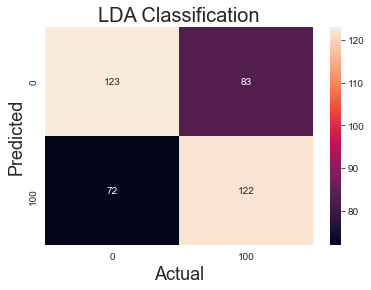

In [30]:
#  confusion matrix plotting for LDA
confusion(y_test, 
             clf_lda.predict(X_test), ["0","100"], 2, 
             'LDA Classification')

In [31]:
# Compute and display accuracy score for random forest
rfc_score = 100.0 * clf_rfc.score(X_test, y_test)
print(f"Random Forest prediction accuracy = {rfc_score:5.1f}%")
print(classification_report(y_test, clf_rfc.predict(X_test)))

Random Forest prediction accuracy =  86.0%
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       206
           1       0.82      0.91      0.86       194

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



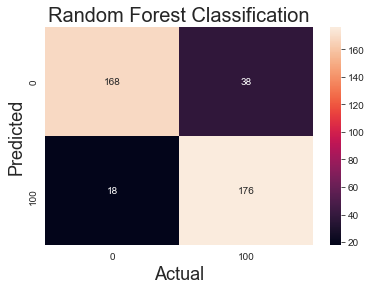

In [32]:
#  confusion matrix plotting for random forest
confusion(y_test, 
             clf_rfc.predict(X_test), ["0","100"], 2, 
             'Random Forest Classification')

In [33]:
y_test_b=np.where(y_test == 100, 1, 0)

In [62]:
# Compute and display accuracy score for xgb
#xgb_score = 100.0 * clf_xgb.score(X_test, y_test)
#print(f"XGboost prediction accuracy = {xgb_score:5.1f}%")
#print(classification_report(y_test_b, clf_xgb.predict(X_test)))

In [36]:
# Compute and display accuracy score for gbtc
gbtc_score = 100.0 * clf_gbtc.score(X_test, y_test)
print(f"Gradient Boosting prediction accuracy = {gbtc_score:5.1f}%")
print(classification_report(y_test, clf_gbtc.predict(X_test)))

Gradient Boosting prediction accuracy =  88.2%
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       206
           1       0.84      0.93      0.89       194

    accuracy                           0.88       400
   macro avg       0.89      0.88      0.88       400
weighted avg       0.89      0.88      0.88       400



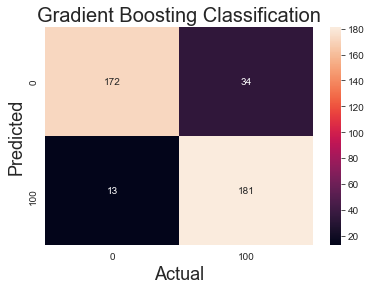

In [37]:
#  confusion matrix plotting for Gradient Boosting Classification
confusion(y_test, 
             clf_gbtc.predict(X_test), ["0","100"], 2, 
             'Gradient Boosting Classification')

# Le modèle sélectionné est le Gradient Boosting Classifier avec une accuracy de 88.2 %.

# Enregistrement du modèle sélectionné dans un fichier pickle 

In [64]:
pip install joblib



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [66]:
import joblib

# Enregistrer le modèle dans un fichier
joblib.dump(clf_gbtc, 'trained_model.pkl')


['trained_model.pkl']